In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# text summarization

In [3]:
df = pd.read_json(open("data/text_summarization_result.txt", "r", encoding="utf8"), lines=True)

In [4]:
df.head()

,rouge1,rouge2,rougeL,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1
0,0.473684,0.162162,0.315789,000571afe702684d90c1d222ce70b1e1375c1016,WatermarkLogitsProcessor_John(vocab_size=50264...,0.369737,0.411828,0.391463
1,0.395210,0.145455,0.239521,000642916e3a6c33411c617cf2f3c134a206fba8,WatermarkLogitsProcessor_John(vocab_size=50264...,0.326795,0.366325,0.347328
2,0.486486,0.238532,0.324324,00110802bc6eae0e8e4d3d22e27f458f41be2b22,WatermarkLogitsProcessor_John(vocab_size=50264...,0.572992,0.497513,0.535271
3,0.376471,0.192771,0.329412,00119229166ae09a6ef25c0e10b101ef9eb9cca3,WatermarkLogitsProcessor_John(vocab_size=50264...,0.322187,0.491463,0.404145
4,0.360000,0.163265,0.240000,0013aa16650fbcfbe6edb16ac614ad174cb5d1cf,WatermarkLogitsProcessor_John(vocab_size=50264...,0.366118,0.383717,0.375804


In [5]:
# nested dict to dataframe
show_wp = ["No Watermark", "$\delta$-reweight", "$\gamma$-reweight"]
john_wps = set()


def map_wp_str(wp_str):
    if "Delta" in wp_str:
        return show_wp[1]
    elif "Gamma" in wp_str:
        return show_wp[2]
    elif "John" in wp_str:
        import re

        delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
        n = "Soft Red List" + f"($\delta$={delta})"
        john_wps.add(n)
        return n
    if wp_str == "None":
        return show_wp[0]
    else:
        raise ValueError("Unknown watermark: {}".format(wp_str))

df = df.assign(wp_str=df["watermark_processor"].apply(map_wp_str))
john_wps = sorted(list(john_wps))
df.head()

,rouge1,rouge2,rougeL,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1,wp_str
0,0.473684,0.162162,0.315789,000571afe702684d90c1d222ce70b1e1375c1016,WatermarkLogitsProcessor_John(vocab_size=50264...,0.369737,0.411828,0.391463,Soft Red List($\delta$=2.0)
1,0.395210,0.145455,0.239521,000642916e3a6c33411c617cf2f3c134a206fba8,WatermarkLogitsProcessor_John(vocab_size=50264...,0.326795,0.366325,0.347328,Soft Red List($\delta$=2.0)
2,0.486486,0.238532,0.324324,00110802bc6eae0e8e4d3d22e27f458f41be2b22,WatermarkLogitsProcessor_John(vocab_size=50264...,0.572992,0.497513,0.535271,Soft Red List($\delta$=2.0)
3,0.376471,0.192771,0.329412,00119229166ae09a6ef25c0e10b101ef9eb9cca3,WatermarkLogitsProcessor_John(vocab_size=50264...,0.322187,0.491463,0.404145,Soft Red List($\delta$=2.0)
4,0.360000,0.163265,0.240000,0013aa16650fbcfbe6edb16ac614ad174cb5d1cf,WatermarkLogitsProcessor_John(vocab_size=50264...,0.366118,0.383717,0.375804,Soft Red List($\delta$=2.0)


Text(0.5, 0, 'Watermark')

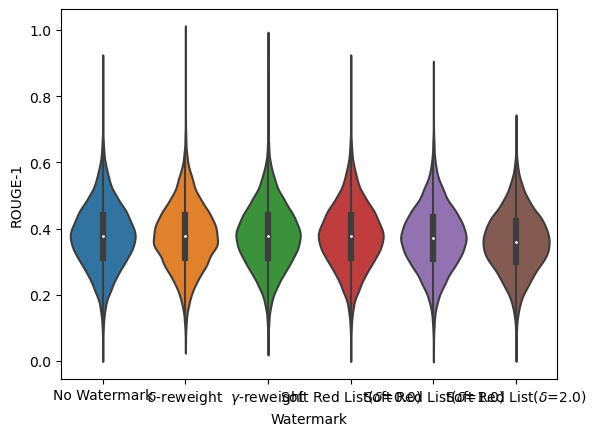

In [6]:
import seaborn as sns

sns.violinplot(
    data=df, x="wp_str", y="rouge1", order=show_wp + john_wps
)
plt.ylabel("ROUGE-1")
plt.xlabel("Watermark")

In [7]:
sdf=df.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in df.columns if df[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
sdf = sdf.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
sdf = sdf.loc[show_wp + john_wps]
sdf

score,bertscore.f1,bertscore.precision,bertscore.recall,rouge1,rouge2,rougeL
wp_str,,,,,,
No Watermark,0.3175±0.0008,0.3058±0.0009,0.3295±0.0010,0.3774±0.0009,0.1323±0.0007,0.2380±0.0007
$\delta$-reweight,0.3181±0.0008,0.3072±0.0009,0.3293±0.0010,0.3776±0.0009,0.1337±0.0008,0.2396±0.0008
$\gamma$-reweight,0.3178±0.0008,0.3061±0.0009,0.3296±0.0010,0.3772±0.0009,0.1332±0.0007,0.2386±0.0007
Soft Red List($\delta$=0.0),0.3175±0.0008,0.3058±0.0009,0.3295±0.0010,0.3774±0.0009,0.1323±0.0007,0.2380±0.0007
Soft Red List($\delta$=1.0),0.3120±0.0008,0.2949±0.0009,0.3294±0.0009,0.3719±0.0009,0.1274±0.0007,0.2326±0.0007
Soft Red List($\delta$=2.0),0.2996±0.0008,0.2751±0.0008,0.3246±0.0009,0.3610±0.0009,0.1166±0.0007,0.2215±0.0007


# translation

In [8]:
df = pd.read_json(open("data/machine_translation_result.txt", "r", encoding="utf8"), lines=True)

In [9]:
df.head()

,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1
0,02221c94eb10b922d52759cfde902a584fc811ae,WatermarkLogitsProcessor_John(vocab_size=58101...,0.191762,0.292634,0.241945
1,02223d119141510bdfacb6b67cec20e9d08440f2,WatermarkLogitsProcessor_John(vocab_size=58101...,0.499746,0.601046,0.549874
2,0222d690dc2e4301cd5ade3989f2d4c1a7606594,WatermarkLogitsProcessor_John(vocab_size=58101...,0.065682,0.102812,0.085399
3,0223f1b22e8eb7ef53e3aa87c7a4cc4445430715,WatermarkLogitsProcessor_John(vocab_size=58101...,0.092905,0.159933,0.127065
4,022418247bcb0a1b009d2e02a0ba44eac2f80b78,WatermarkLogitsProcessor_John(vocab_size=58101...,0.476234,0.540548,0.508631


In [10]:
john_wps = set()
df = df.assign(wp_str=df["watermark_processor"].apply(map_wp_str))
john_wps = sorted(list(john_wps))
df.head()

,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1,wp_str
0,02221c94eb10b922d52759cfde902a584fc811ae,WatermarkLogitsProcessor_John(vocab_size=58101...,0.191762,0.292634,0.241945,Soft Red List($\delta$=0.0)
1,02223d119141510bdfacb6b67cec20e9d08440f2,WatermarkLogitsProcessor_John(vocab_size=58101...,0.499746,0.601046,0.549874,Soft Red List($\delta$=0.0)
2,0222d690dc2e4301cd5ade3989f2d4c1a7606594,WatermarkLogitsProcessor_John(vocab_size=58101...,0.065682,0.102812,0.085399,Soft Red List($\delta$=0.0)
3,0223f1b22e8eb7ef53e3aa87c7a4cc4445430715,WatermarkLogitsProcessor_John(vocab_size=58101...,0.092905,0.159933,0.127065,Soft Red List($\delta$=0.0)
4,022418247bcb0a1b009d2e02a0ba44eac2f80b78,WatermarkLogitsProcessor_John(vocab_size=58101...,0.476234,0.540548,0.508631,Soft Red List($\delta$=0.0)


Text(0.5, 0, 'Watermark')

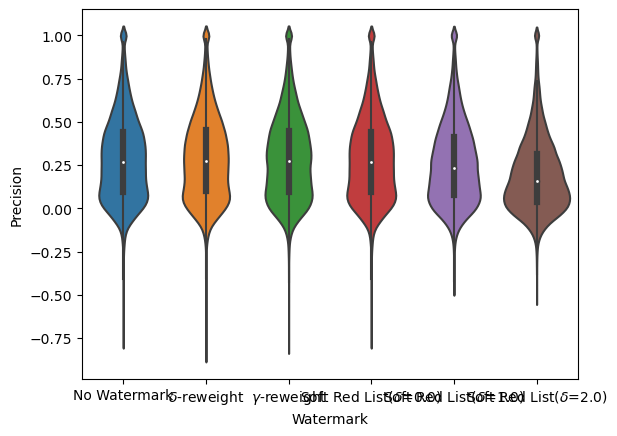

In [11]:
import seaborn as sns

sns.violinplot(
    data=df, x="wp_str", y="bertscore.precision", order=show_wp + john_wps
)
plt.ylabel("Precision")
plt.xlabel("Watermark")

In [12]:
sdf=df.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in df.columns if df[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
sdf = sdf.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
sdf = sdf.loc[show_wp + john_wps]
sdf

score,bertscore.f1,bertscore.precision,bertscore.recall
wp_str,,,
No Watermark,0.3008±0.0010,0.2874±0.0010,0.3152±0.0010
$\delta$-reweight,0.3040±0.0010,0.2909±0.0010,0.3181±0.0010
$\gamma$-reweight,0.3029±0.0010,0.2896±0.0010,0.3172±0.0010
Soft Red List($\delta$=0.0),0.3008±0.0010,0.2874±0.0010,0.3152±0.0010
Soft Red List($\delta$=1.0),0.2777±0.0009,0.2605±0.0010,0.2960±0.0010
Soft Red List($\delta$=2.0),0.2188±0.0009,0.1946±0.0009,0.2444±0.0009
